In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.animation as animation
from Losses import distance_matrix_vector
from Losses import loss_HardNet
from copy import deepcopy
import imageio
import matplotlib.pylab as pylab
import scipy
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.rcParams['axes.facecolor'] = (0.95,0.95,0.95)
plt.rcParams['grid.color'] = 'white'
    
def get_input_param_optimizer(x, lr):
    input_param = nn.Parameter(x.data)
    optimizer = optim.Adam([input_param], lr=lr)
    return input_param, optimizer
def distance_vectors_pairwise(anchor, positive, negative = None):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    a_sq = torch.sum(anchor * anchor, dim=1)
    p_sq = torch.sum(positive * positive, dim=1)

    eps = 1e-8
    d_a_p = torch.sqrt(a_sq + p_sq - 2*torch.sum(anchor * positive, dim = 1) + eps)
    if negative is not None:
        n_sq = torch.sum(negative * negative, dim=1)
        d_a_n = torch.sqrt(a_sq + n_sq - 2*torch.sum(anchor * negative, dim = 1) + eps)
        d_p_n = torch.sqrt(p_sq + n_sq - 2*torch.sum(positive * negative, dim = 1) + eps)
        return d_a_p, d_a_n, d_p_n
    return d_a_p
def loss_HardNegC(anchor, positive, margin = 1.0):
    assert anchor.size() == positive.size(), "Input sizes between positive and negative must be equal."
    assert anchor.dim() == 2, "Inputd must be a 2D matrix."
    eps = 1e-8
    dist_matrix_detach = distance_matrix_vector(anchor, positive.detach()) + eps
    pos1 = distance_vectors_pairwise(anchor,positive)
    eye = torch.autograd.Variable(torch.eye(dist_matrix_detach.size(1))).cuda()
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag = dist_matrix_detach + eye*10
    mask = (dist_without_min_on_diag.ge(0.0008).float()-1)*-1
    mask = mask.type_as(dist_without_min_on_diag)*10
    dist_without_min_on_diag = dist_without_min_on_diag + mask
    min_neg = torch.min(dist_without_min_on_diag,1)[0]
    #loss = 0.5 * torch.mean(loss)
    dist_matrix_detach2 = distance_matrix_vector(anchor.detach(), positive) + eps
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag2 = dist_matrix_detach2 + eye*10
    mask2 = (dist_without_min_on_diag2.ge(0.0008).float()-1)*-1
    mask2 = mask2.type_as(dist_without_min_on_diag2)*10
    dist_without_min_on_diag2 = dist_without_min_on_diag2 + mask2
    min_neg2 = torch.min(dist_without_min_on_diag2,0)[0]
    #min_neg_all = torch.min(min_neg.view(-1),min_neg2.view(-1))
    #print min_neg_all.shape
    loss = torch.clamp(margin + pos1 - 0.5*(min_neg2 + min_neg), min=0.0).mean()
    return loss
def detach2(a,p):
    return 0.5* (loss_HardNegC(a,p) + loss_HardNegC(p,a))
def posdist(a1,p1):
    return torch.sqrt(((a1-p1)**2).sum(dim=1) + 1e-12).mean()
def reinitpts(points):
    a = torch.from_numpy(deepcopy(points.astype(np.float32)[:,0,::-1]))
    p = torch.from_numpy(deepcopy(points.astype(np.float32)[:,1,::-1]))
    a1,opt1 = get_input_param_optimizer(a.cuda(),0.01)
    p1,opt2 = get_input_param_optimizer(p.cuda(),0.01)
    return a1,p1,opt1,opt2
def optimize(a1,p1,opt1,opt2,lf, steps = 100, n = 0):
    atraj = []
    ptraj = []
    avtraj = []
    pvtraj = []
    for step in range(steps):
        atraj.append(a1.cpu().detach().unsqueeze(0).numpy())
        ptraj.append(p1.cpu().detach().unsqueeze(0).numpy())
        loss = lf(a1,p1) + n*(torch.clamp( torch.abs(a1) - 1, min = 0) + \
                              torch.clamp( torch.abs(p1) - 1, min = 0)).sum()
        if step == steps-1 and loss < 1e-2:
            loss = loss * 0;
        opt1.zero_grad()
        opt2.zero_grad()
        loss.backward() 
        opt1.step()
        opt2.step()
        avtraj.append(a1.grad.cpu().detach().unsqueeze(0).numpy())
        pvtraj.append(p1.grad.cpu().detach().unsqueeze(0).numpy())

    return np.concatenate(atraj, axis = 0), np.concatenate(ptraj),\
            np.concatenate(avtraj), np.concatenate(pvtraj) 
def visualize(fig,ax, a,p,av,pv,colors, atr = [], ptr = [], step = 0):
    if len(atr) > 0:
        for idx in range(atr.shape[1]):
            xprev = [atr[:,idx,0], ptr[:,idx,0]]
            yprev = [atr[:,idx,1], ptr[:,idx,1]]
            ax.plot(xprev,yprev, marker='.', color = colors[idx], linestyle = ' ',alpha = 0.5,  markerSize = 5)
    #Current state
    x = np.array([a[:,0], p[:,0]])
    y = np.array([a[:,1], p[:,1]])
    xv = np.array([-av[:,0], -pv[:,0]]) * 1.0
    yv = np.array([-av[:,1], -pv[:,1]]) * 1.0
    for idx in range(x.shape[1]):
        ax.add_artist(plt.quiver(x[:,idx], y[:,idx],
                                 xv[:,idx], yv[:,idx], color = colors[idx], 
                                 pivot = 'tail', scale = 3.0,width = 0.01))
        ax.plot(x[:,idx], y[:,idx], marker='o', color = colors[idx],  markerSize = 20,linestyle = ' ')
    ax.plot(x,y, 'ow', markerSize = 12)
    mean_pos_dist = np.sqrt(((a - p)**2).sum(axis = 1) + 1e-12).mean()
    #print mean_pos_dist
    dm =  scipy.spatial.distance.cdist(a,p) 
    mean_closes_neg_dist = np.minimum((dm+ 10*np.eye(dm.shape[0])).min(axis = 1), (dm+ 10*np.eye(dm.shape[0])).min(axis = 0))
    #print mean_closes_neg_dist.mean()
    ax.text(-1.4, 1.3, 'Avg. positive dist.         = '+str(mean_pos_dist)[:4], fontsize=20)
    ax.text(-1.4, 0.3+0.85, 'Avg. min negative dist. = '+str(mean_closes_neg_dist.mean())[:4], fontsize=20)
    ax.text(-1.4, 0.3+0.70, 'Step = '+str(step), fontsize=20)
    return 
def fig2img ( fig ):
    w,h = fig.canvas.get_width_height()
    return  np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(w, h, 3) 
def produce_img_seq(atraj, ptraj,av,pv, title = "HardNegLoss"):
    fig, ax = plt.subplots(1,1,figsize=(6, 6))
    fig.tight_layout(pad=0)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    ax.set_aspect('equal', adjustable='box')
    params = {'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    plt.title(title)
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
    ax.tick_params(labelsize = 20)
    ax.title.set_size(20)
    plt.rcParams['axes.facecolor'] = (0.95,0.95,0.95)
    ax.grid(color='w', linestyle=':', linewidth=2)
    out_imgs = []
    num_frames = len(atraj)
    for step in range(num_frames):
        if step % 20 == 0:
            print (step)
        ax.clear()
        fig.tight_layout(pad=0)
        ax.set_xlim([-1.5,1.5])
        ax.set_ylim([-1.5,1.5])
        ax.set_aspect('equal', adjustable='box')
        plt.rcParams['axes.facecolor'] = (0.95,0.95,0.95)
        ax.grid(color='w', linestyle=':', linewidth=2)
        visualize(fig,ax, 
                  atraj[step],
                  ptraj[step],
                  av[step],
                  pv[step],
                  colors,
                  atr = atraj[:step], 
                  ptr = ptraj[:step], step = step)
        plt.title(title)
        ax.yaxis.label.set_size(20)
        ax.xaxis.label.set_size(20)
        ax.tick_params(labelsize = 20)
        ax.title.set_size(20)
        fig.canvas.draw()
        out_imgs.append(fig2img(fig))
    return out_imgs

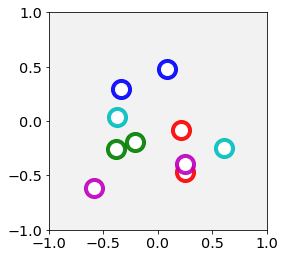

In [104]:
try:
    points = np.load('points_from_paper.npy')
    print ('Points loaded')
except:
    points = np.random.uniform(-0.7,0.7, (5,2,2))
colors = ['r','g','b','m','c','y', 'k']
plt.rcParams['axes.facecolor'] = (0.95,0.95,0.95)
plt.rcParams['grid.color'] = 'white'
for i in range(len(points)):
    x = points[i,:,1]
    y = points[i,:,0]
    plt.plot(x,y, 'o'+colors[i], markerSize = 20, alpha = 0.9)
    plt.plot(x,y, 'ow', markerSize = 12)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

0
20
40
60
80
100
120
140


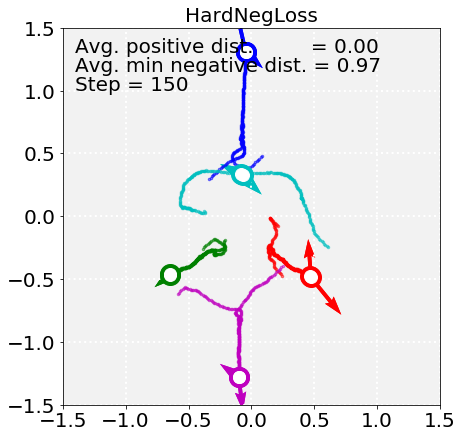

In [105]:

a1,p1, opt1,opt2 = reinitpts(points)
atraj, ptraj, avtraj, pvtraj = optimize(a1,p1,opt1,opt2,
                                        lf = loss_HardNet, steps = 151, n = 0)
imgs = produce_img_seq(atraj, ptraj, avtraj, pvtraj, 'HardNegLoss')

writer = imageio.get_writer('HardNegLoss1.gif', fps=10)
for cur_img in imgs:
    writer.append_data(cur_img)
writer.close()

In [ ]:

a1,p1, opt1,opt2 = reinitpts(points)
atraj, ptraj, avtraj, pvtraj = optimize(a1,p1,opt1,opt2,
                                        lf = detach2, steps = 151, n = 0)
imgs = produce_img_seq(atraj, ptraj, avtraj, pvtraj,'HardNegCLoss')

writer = imageio.get_writer('HardNegCLoss1.gif', fps=10)
for cur_img in imgs:
    writer.append_data(cur_img)
writer.close()



0
20
40


In [ ]:

a1,p1, opt1,opt2 = reinitpts(points)
atraj, ptraj, avtraj, pvtraj = optimize(a1,p1,opt1,opt2,
                                        lf = posdist, steps = 151, n = 0)
imgs = produce_img_seq(atraj, ptraj, avtraj, pvtraj,'PosDistLoss')

writer = imageio.get_writer('PosDistLoss1.gif', fps=10)
for cur_img in imgs:
    writer.append_data(cur_img)
writer.close()

In [100]:
writer = imageio.get_writer('PosDistLoss.gif', fps=10)
for cur_img in imgs:
    writer.append_data(cur_img)
writer.close()